In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision.io import read_image
from torchvision import datasets, transforms    
# For utilities
import os, shutil, time
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io, color
from sklearn.model_selection import train_test_split
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
from skimage.transform import resize

# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
])

class RGBtoGrayDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        target = self.file_list[idx]
        img = io.imread(target)
        img_original = np.asarray(img)
        img_original = resize(img_original, (224, 224), anti_aliasing=True)
        img_lab = rgb2lab(img_original)
        img_lab = (img_lab + 128) / 255
        img_ab = img_lab[:, :, 1:3]
        img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
        img_original = rgb2gray(img_original)
        img_original = torch.from_numpy(img_original).unsqueeze(0).float()

        if self.transform is not None:
            img_original = self.transform(img_original)

        return img_original, img_ab, img


# Pfade zu den Bildern
image_dir = 'dataset/student_dataset/train/images'
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]

# Aufteilung in Trainings- und Validierungsbilder
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Apply augmentation only to the training dataset
train_dataset = RGBtoGrayDataset(train_files, transform=augmentation_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Erstellen des Validierungsdatasets und Dataloaders
val_dataset = RGBtoGrayDataset(val_files)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
def count_jpg_files(folder_path):
    jpg_count = 0

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):
            jpg_count += 1

    return jpg_count

# Ordnerpfad zum Dataset
dataset_folder = 'dataset/student_dataset/train/images'

# Anzahl der JPG-Dateien im Dataset-Ordner
jpg_file_count = count_jpg_files(dataset_folder)
print(f"Anzahl der JPG-Dateien: {jpg_file_count}")


In [ ]:
def print_dataset_size(dataset):
    print(f"Dataset Size: {len(dataset)}")

# Ausgabe der Größe des Trainingsdatensatzes
print_dataset_size(train_dataset)

# Ausgabe der Größe des Validierungsdatensatzes
print_dataset_size(val_dataset)


In [ ]:
import torch.nn.init as init

class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 512

    ## First half: ResNet
    resnet = models.resnet50(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

    # Initialize the weights
    self._initialize_weights()

  def _initialize_weights(self):
      for module in self.modules():
          if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
              # Apply Xavier or He initialization
              init.kaiming_uniform_(module.weight)
              if module.bias is not None:
                  module.bias.data.zero_()

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))
  
  return color_image

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update learning rate scheduler
    scheduler.step(loss)

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 300

In [ ]:
best_losses = float('inf')
patience = 3  # Number of epochs to wait for improvement
counter = 0  # Counter to track the number of epochs without improvement

for epoch in range(epochs):
    # Train for one epoch, then validate
    train(train_loader, model, criterion, optimizer, epoch)
    
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
    
    # Save checkpoint and replace old best model if current model is better
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1, losses))
        counter = 0  # Reset the counter since there was improvement
    else:
        counter += 1  # Increment the counter if there was no improvement
        
        # Check if early stopping criterion is met
        if counter >= patience:
            print("Validation loss did not improve for {} epochs. Stopping training.".format(patience))
            break

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def to_rgb_new(grayscale_input, ab_input, save_path=None, save_name=None):
    plt.clf()  # Clear matplotlib
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy()  # Combine channels
    color_image = color_image.transpose((1, 2, 0))  # Rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()#
    print(save_path)
    print(save_name)
    print(os.path.join(save_path, save_name))
    if save_path is not None and save_name is not None:
        plt.imsave(fname=os.path.join(save_path, save_name), arr=color_image)

    return color_image


def test(test_loader, model):
    model.eval()

    # Create folder to save predicted images
    save_path = "test_pred"
    if not os.path.exists("test_pred"):
        os.makedirs("test_pred")

    for i, (input_gray, _) in enumerate(test_loader):
        # Use GPU
        if use_gpu:
            input_gray = input_gray.cuda()

        # Run model
        output_ab = model(input_gray)  # throw away class predictions
        
        for j in range(len(output_ab)):
            save_name = 'img-{}.jpg'.format(i * test_loader.batch_size + j)
            save_path_img = save_path
            to_rgb_new(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path_img, save_name=save_name)

    print('Finished testing.')

# Define the path to the test dataset
test_data_path = "dataset/student_dataset/test_color"

# Define the transformation to be applied to the test images
# Define the transformation to be applied to the test images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale (1 channel)
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Create the test dataset
test_dataset = ImageFolder(test_data_path, transform=transform)

# Create the test loader
batch_size = 16  # Specify the batch size for the test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = ColorizationNet()
model.load_state_dict(torch.load('checkpoints/model-epoch-9-losses-0.000.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

test(test_loader, model)


In [ ]:
import os
from PIL import Image
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the folder containing the JPEG files
folder_path = "test_pred"

# Initialize an empty array to store the images
image_array = np.zeros((50, 224, 224, 3), dtype=np.uint8)

# List all files in the folder
files = os.listdir(folder_path)
files = sorted(files, key=lambda x: int(re.findall(r'\d+', x)[0]))
print(files)
# Iterate over each file in the folder
for i, file_name in enumerate(files):
    
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Read the image using PIL
    image = Image.open(file_path)
    
    # Convert the image to a NumPy array
    image_array[i] = np.array(image)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels
    plt.show()
        
# Save the array as a NumPy file
np.save("image_array.npy", image_array)

# Print the shape of the resulting array
print("Array shape:", image_array.shape)
print("Array saved as 'image_array.npy'")


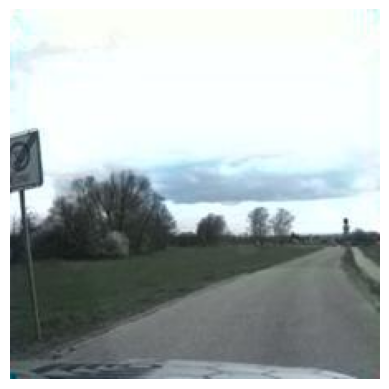

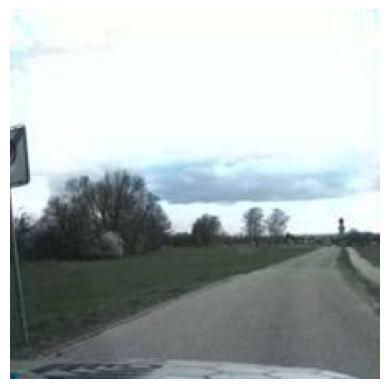

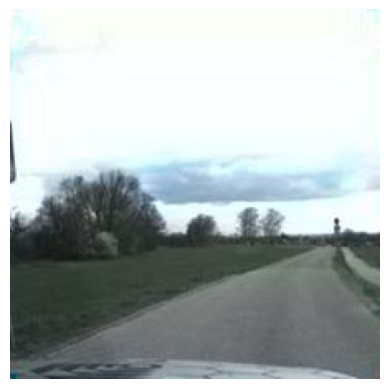

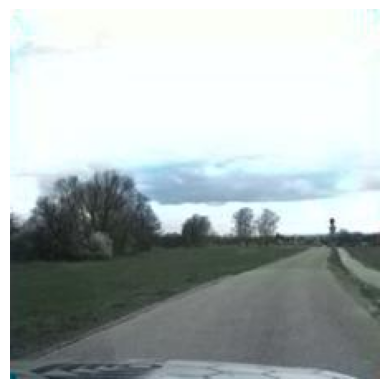

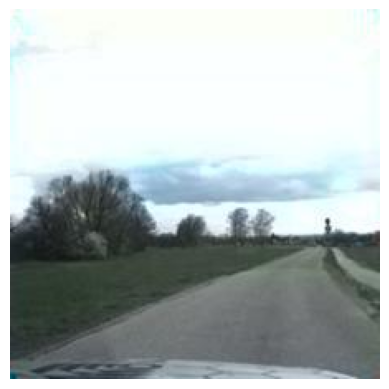

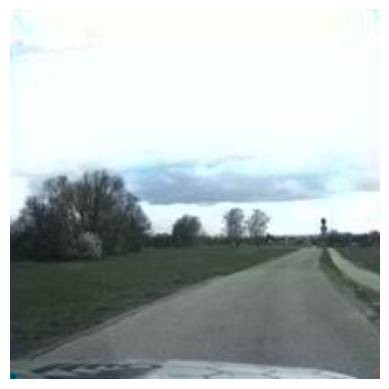

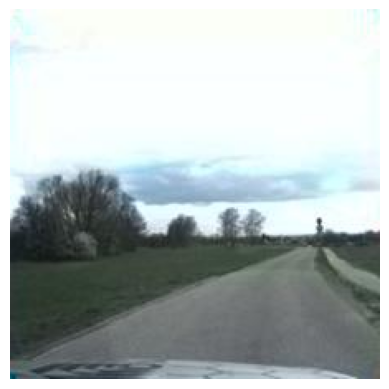

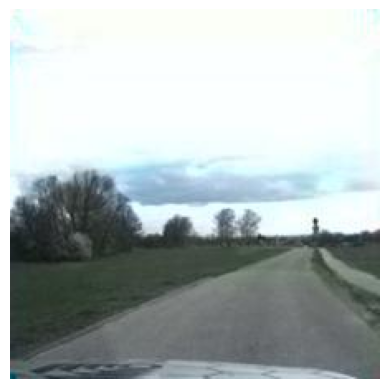

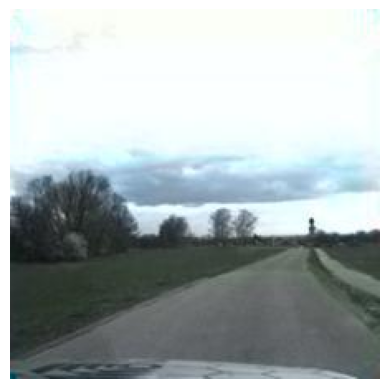

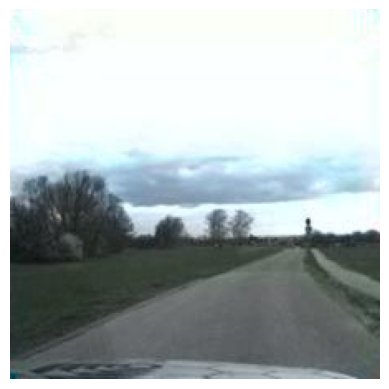

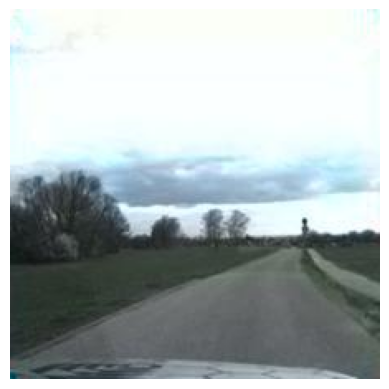

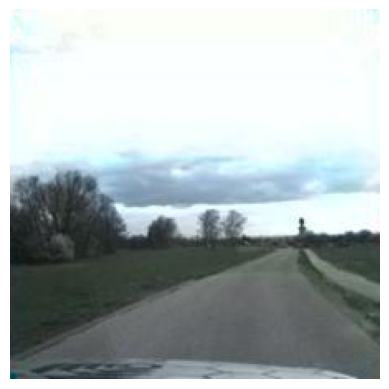

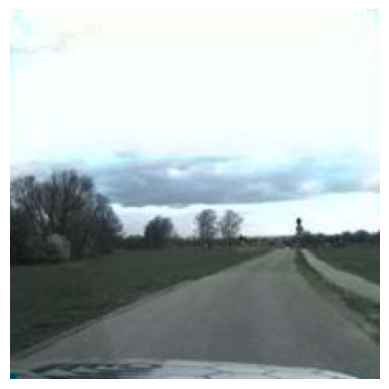

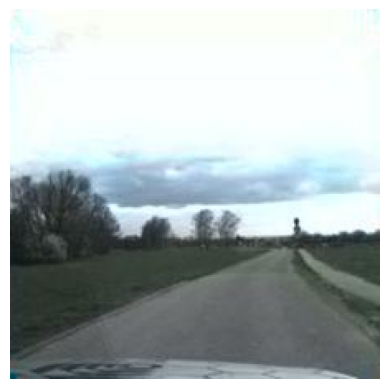

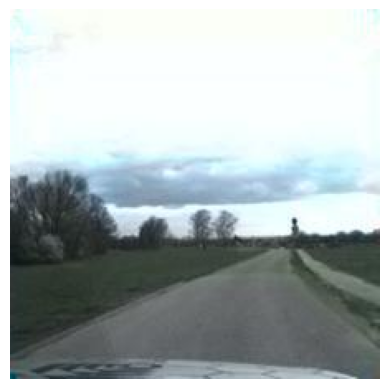

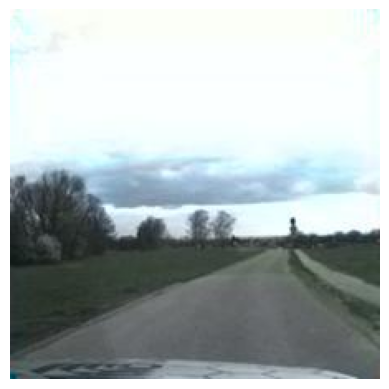

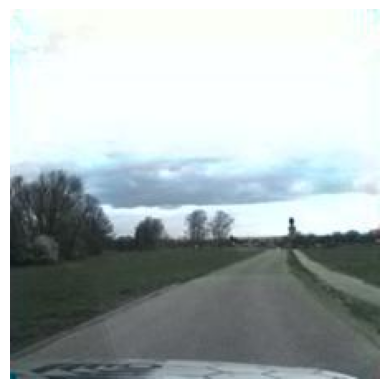

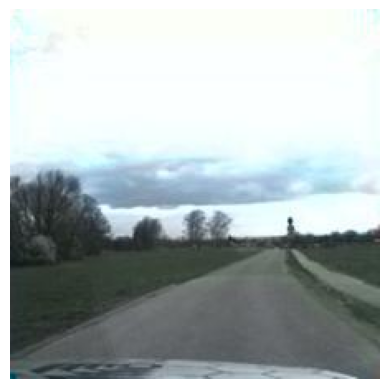

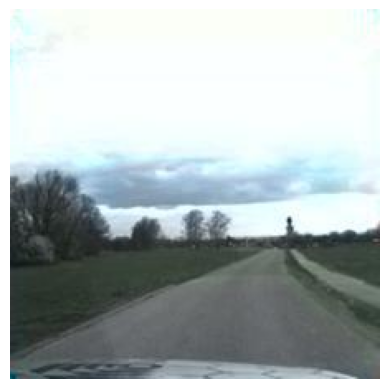

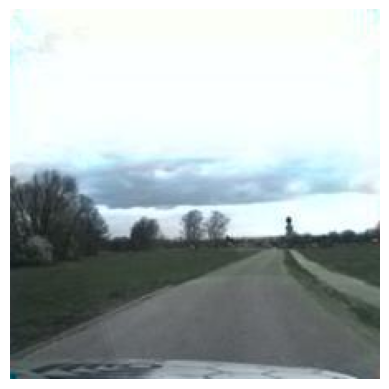

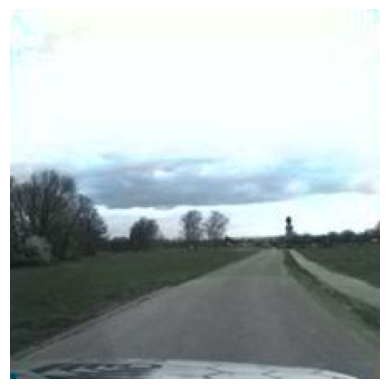

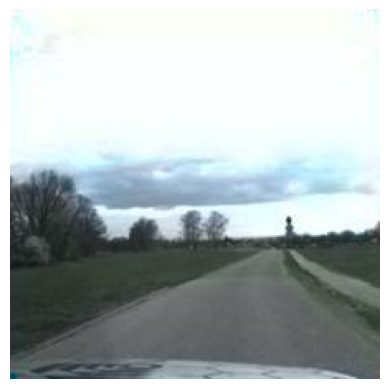

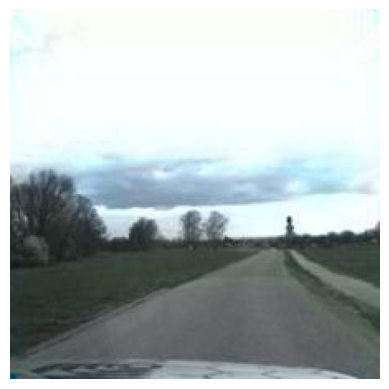

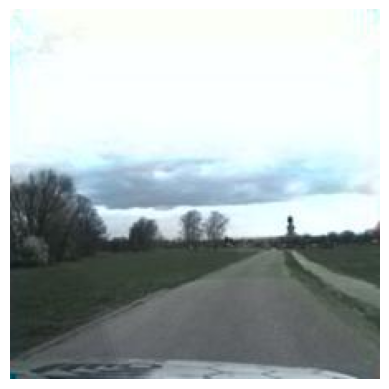

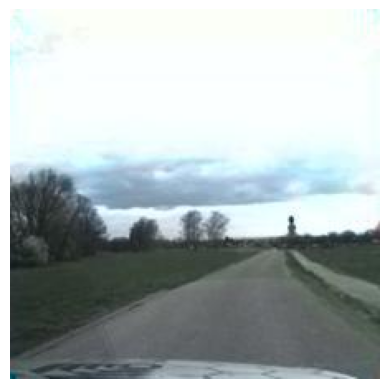

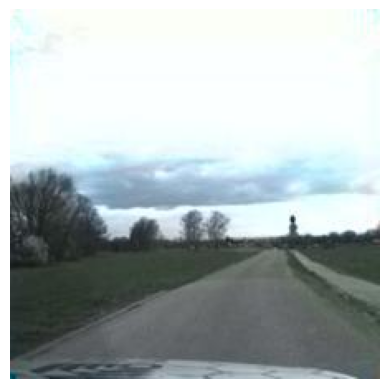

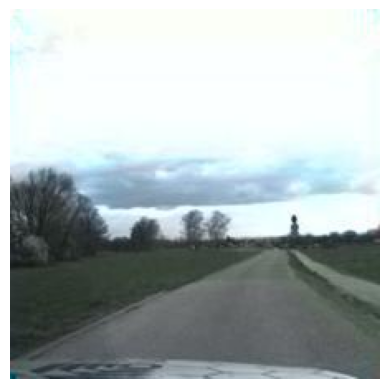

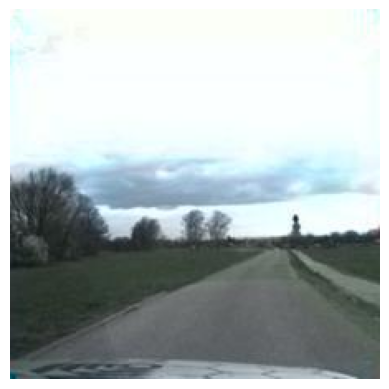

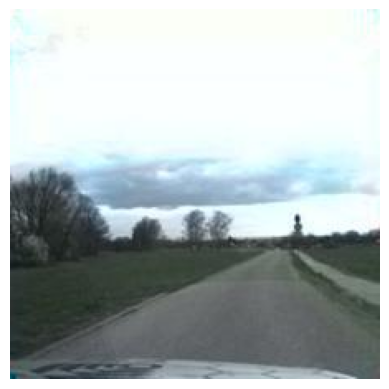

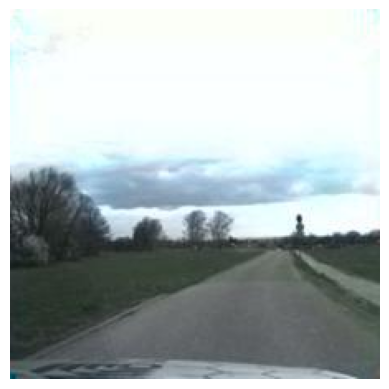

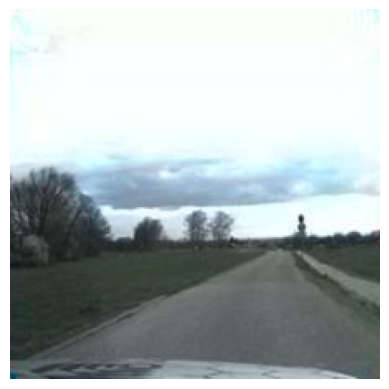

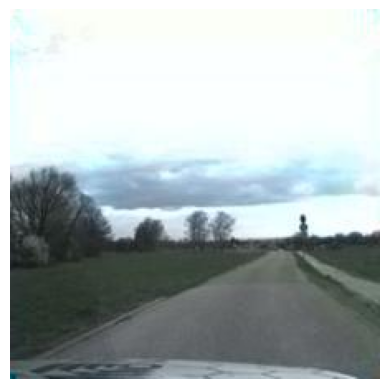

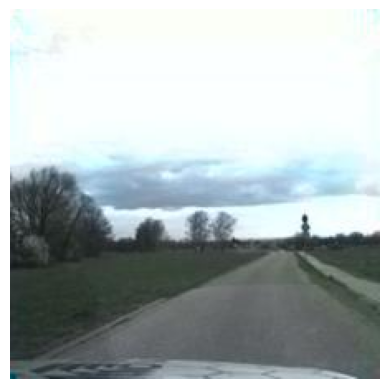

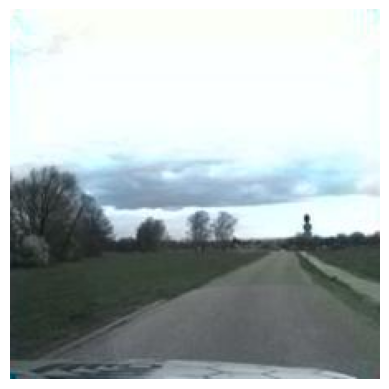

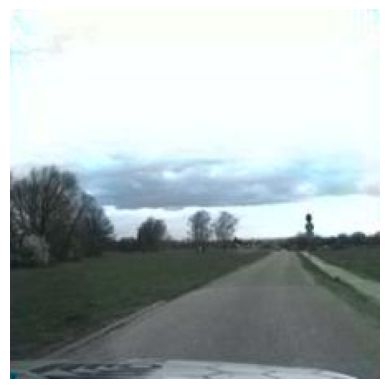

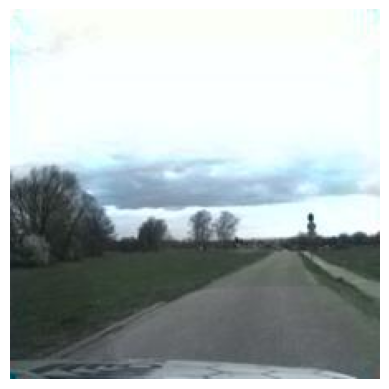

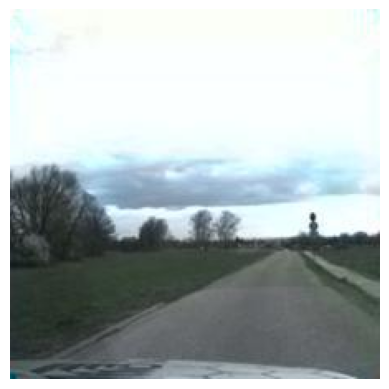

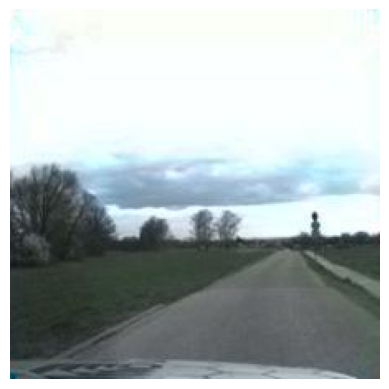

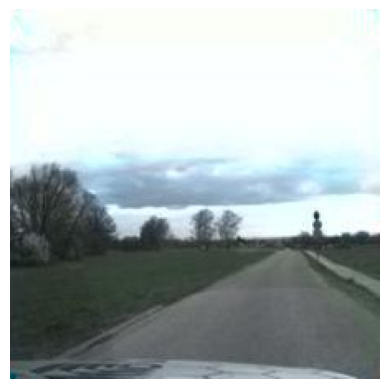

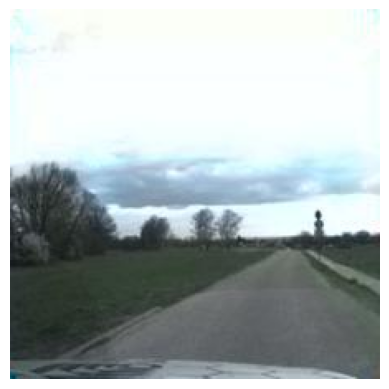

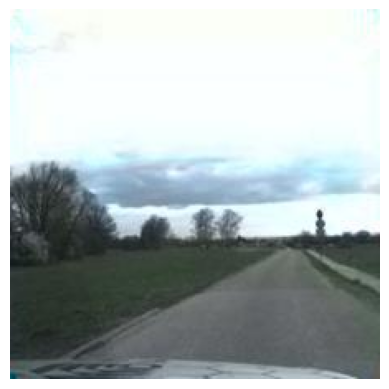

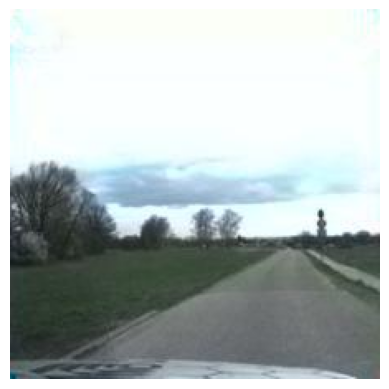

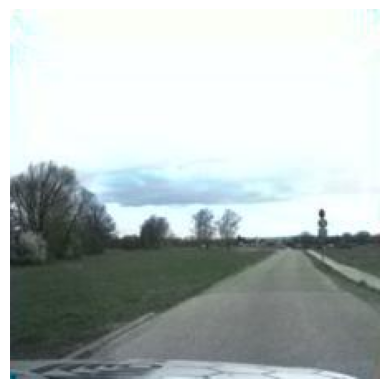

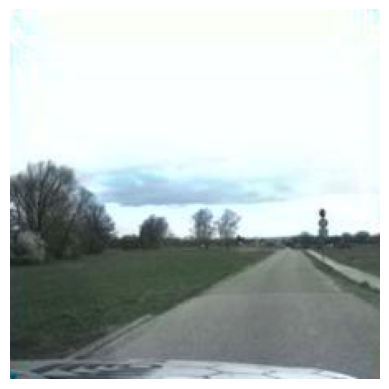

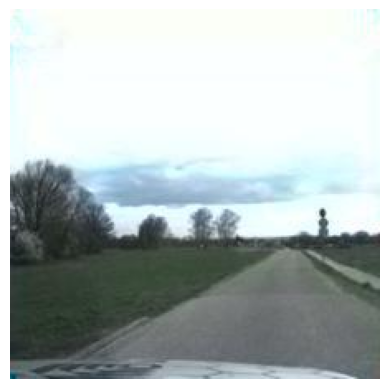

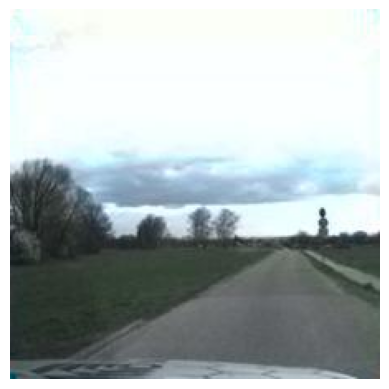

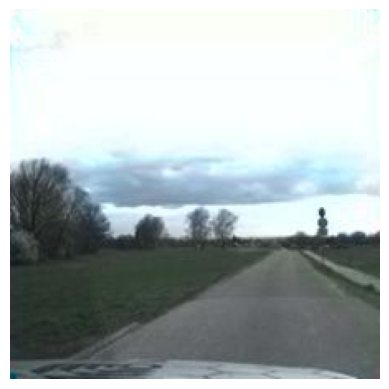

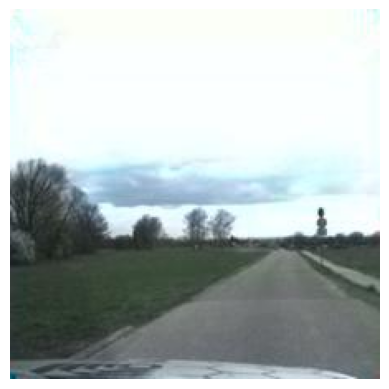

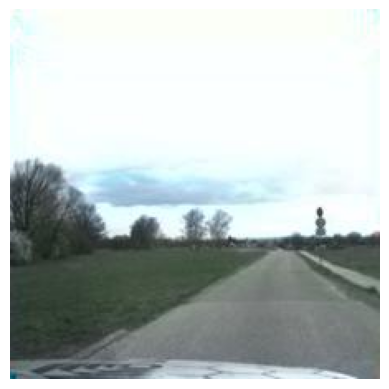

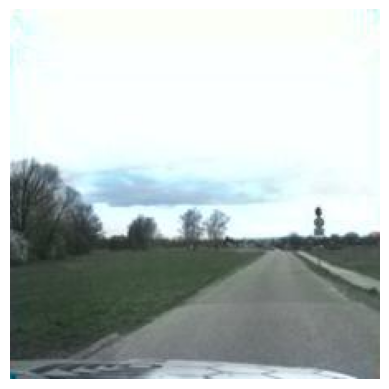

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image array from the saved NumPy file
image_array = np.load("image_array.npy")

# Iterate over each image in the array
for i in range(image_array.shape[0]):
    # Get the image
    image = image_array[i]
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()